# Türkiye İlleri Bölge Grupları Haritası

Bu notebook, Türkiye'nin illerini 10 farklı gruba ayırarak renkli bir harita oluşturmayı amaçlamaktadır. Her grup farklı bir renkle temsil edilecektir.

İller belirlenmiş gruplara göre ayrılmış ve her grup için özel renkler tanımlanmıştır.

## Gerekli Kütüphanelerin Kurulumu

Öncelikle bu notebook'u çalıştırmak için gerekli paketleri kuralım. GeoPandas kütüphanesi bazı bağımlılıklara sahiptir ve doğru kurulması önemlidir.

In [75]:
# sudo izni gerektirmeden pip ile gerekli kütüphaneleri kuralım
!pip install --user geopandas matplotlib pandas numpy adjustText

# Alternatif olarak, eğer yukarıdaki komut çalışmazsa:
# !python -m pip install --user geopandas

# Kurulumdan sonra kütüphanelerin doğru yüklendiğini kontrol et
try:
    import geopandas
    print("GeoPandas başarıyla kuruldu!")
except ImportError as e:
    print(f"Kurulum sorunu oluştu: {e}")

GeoPandas başarıyla kuruldu!
GeoPandas başarıyla kuruldu!


## Gerekli Kütüphanelerin Yüklenmesi

Öncelikle haritayı oluşturmak için gerekli olan Python kütüphanelerini yükleyelim.

In [76]:
# Gerekli kütüphaneleri içe aktaralım
import geopandas as gp
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import adjustText as aT  # İl isimlerinin harita üzerinde düzgün yerleşimi için
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import matplotlib.patheffects as path_effects  # patheffects modülünü doğru şekilde içe aktar

## Veri Yükleme

Türkiye illerinin coğrafi verilerini içeren shapefile dosyasını yükleyelim.

In [77]:
# Türkiye illeri shapefile dosyasını doğru konumdan yükle
# Shapefile dosyasını GitHub'dan doğrudan indirme seçeneği ekleyelim
import os
import subprocess

# Shape dosyasını bulma veya indirme
shapefile_path = 'TUR_adm1.shp'
if not os.path.exists(shapefile_path):
    shapefile_path = 'Konum_Verileri/TUR_adm1.shp'
    
    if not os.path.exists(shapefile_path):
        print("Shapefile bulunamadı, GitHub'dan indirmeyi deniyorum...")
        
        # Klasörü oluştur ve shapefiles indir
        !mkdir -p Konum_Verileri
        !wget -q https://github.com/ozancanozdemir/maps/raw/main/TUR_adm1.shp -O Konum_Verileri/TUR_adm1.shp
        !wget -q https://github.com/ozancanozdemir/maps/raw/main/TUR_adm1.dbf -O Konum_Verileri/TUR_adm1.dbf
        !wget -q https://github.com/ozancanozdemir/maps/raw/main/TUR_adm1.shx -O Konum_Verileri/TUR_adm1.shx
        
        shapefile_path = 'Konum_Verileri/TUR_adm1.shp'
        
        if not os.path.exists(shapefile_path):
            print("Otomatik indirme başarısız! Lütfen TUR_adm1.shp dosyasını manuel olarak yükleyin.")
            # Mevcut klasördeki dosyaları listeleyelim
            print("\nMevcut dizindeki dosyalar:")
            !ls -la
            print("\nKonum_Verileri klasöründeki dosyalar (varsa):")
            !ls -la Konum_Verileri 2>/dev/null || echo "Konum_Verileri klasörü bulunamadı"

print(f"Kullanılacak shapefile: {shapefile_path}")
turkiye_iller = gp.read_file(shapefile_path)
turkiye_iller.head()

Kullanılacak shapefile: Konum_Verileri/TUR_adm1.shp


ID_0  ISO  NAME_0  ID_1     NAME_1 TYPE_1 ENGTYPE_1 NL_NAME_1  \
0   235  TUR  Turkey     1  Çanakkale     Il  Province      None   
1   235  TUR  Turkey     2    Çankiri     Il  Province      None   
2   235  TUR  Turkey     3      Çorum     Il  Province      None   
3   235  TUR  Turkey     4      Adana     Il  Province      None   
4   235  TUR  Turkey     5   Adiyaman     Il  Province      None   

         VARNAME_1                                           geometry  
0             None  MULTIPOLYGON (((26.05347 39.84736, 26.05347 39...  
1  Çankırı|Changra  POLYGON ((33.78607 40.96249, 33.78677 40.95684...  
2             None  POLYGON ((34.81906 41.20172, 34.84486 41.19581...  
3           Seyhan  MULTIPOLYGON (((35.27903 36.64069, 35.27903 36...  
4         Adıyaman  POLYGON ((38.65534 38.09172, 38.66739 38.0916,...

## İllerin Gruplandırılması

İller belirlenmiş gruplara göre ayrılacaktır. Aşağıda her gruba dahil olan illerin listesi bulunmaktadır.

In [78]:
# İl gruplarını tanımlama
province_groups = {
    1: ["Edirne", "Kırklareli", "Tekirdağ", "Yalova", "Kocaeli", "Sakarya", "Düzce", "Bolu"],
    2: ["İzmir", "Manisa", "Aydın", "Denizli", "Muğla", "Çanakkale", "Balıkesir", "Bursa"],
    3: ["Antalya", "Isparta", "Burdur", "Uşak", "Kütahya", "Afyon", "Bilecik", "Eskişehir"],
    4: ["Adana", "Mersin", "Hatay", "Osmaniye", "K. Maraş", "Kayseri", "Gaziantep", "Kilis"],
    5: ["Konya", "Karaman", "Niğde", "Nevşehir", "Kırşehir", "Kırıkkale", "Yozgat", "Aksaray"],
    6: ["Samsun", "Zonguldak", "Bartın", "Karabük", "Sinop", "Kastamonu", "Çankırı", "Çorum"],
    7: ["Trabzon", "Artvin", "Rize", "Giresun", "Ordu", "Amasya", "Tokat", "Sivas"],
    8: ["Erzurum", "Erzincan", "Kars", "Ardahan", "Iğdır", "Ağrı", "Bayburt", "Gümüşhane"],
    9: ["Van", "Batman", "Şırnak", "Siirt", "Bitlis", "Hakkari", "Muş", "Bingöl"],
    10: ["Diyarbakır", "Mardin", "Elazığ", "Malatya", "Adıyaman", "Şanlıurfa", "Tunceli"],
    0: ["Ankara", "İstanbul"]  # Özel grup: Ankara ve İstanbul beyaz renkte gösterilecek
}

## İsimlerin Standartlaştırılması

İl isimlerinde Türkçe karakter sorunları ve yazım farklılıkları olabilir. Bu sorunları gidermek için isimleri standartlaştıralım.

In [79]:
# İl adlarının standartlaştırılması için geliştirilmiş dönüşüm sözlüğü
name_mapping = {
    "K. Maras": "Kahramanmaras",
    "Kahramanmaraş": "Kahramanmaras",
    "Kahramanmaras": "Kahramanmaras",
    "Gümüshane": "Gumushane",
    "Gümüşhane": "Gumushane",
    "Kinkkale": "Kirikkale",
    "Kırıkkale": "Kirikkale",
    "Zinguldak": "Zonguldak",
    "Afyon": "Afyonkarahisar",
    "Kütahya": "Kutahya",
    "Elazığ": "Elazig",
    "Bingöl": "Bingol",
    "Bartın": "Bartin",
    "Karabük": "Karabuk",
    "Düzce": "Duzce",
    "İzmir": "Izmir",
    "Çanakkale": "Canakkale",
    "Balıkesir": "Balikesir",
    "Bilecik": "Bilecik",
    "Eskişehir": "Eskisehir",
    "Uşak": "Usak",
    "Şanlıurfa": "Sanliurfa",
    "Şırnak": "Sirnak",
    "Ağrı": "Agri",
    "Iğdır": "Igdir",
    "Tekirdağ": "Tekirdag",
    "Çorum": "Corum",
    "Çankırı": "Cankiri",
    "Çankiri": "Cankiri",
    "Niğde": "Nigde",
    "Nevşehir": "Nevsehir",
    "Kırşehir": "Kirsehir",
    "Kırklareli": "Kirklareli",
    "Muğla": "Mugla",
    "Mugla": "Mugla",
    "Muş": "Mus",
    "İstanbul": "Istanbul",
    "Istanbul": "Istanbul",
    "Aydın": "Aydin",
    "Aydin": "Aydin",
    "Adıyaman": "Adiyaman",
    "Adiyaman": "Adiyaman",
    "Diyarbakır": "Diyarbakir"
}

# Shapefile'daki il adlarını kontrol edelim
print("Shapefile'daki il adları:")
print(sorted(turkiye_iller['NAME_1'].tolist()))

# İl adlarını standartlaştırma
for old_name, new_name in name_mapping.items():
    turkiye_iller.loc[turkiye_iller['NAME_1'] == old_name, 'NAME_1'] = new_name

# Grup listesindeki il adlarını da standartlaştıralım
standardized_groups = {}
for group_id, provinces in province_groups.items():
    standardized_provinces = []
    for province in provinces:
        if province in name_mapping:
            standardized_provinces.append(name_mapping[province])
        else:
            standardized_provinces.append(province)
    standardized_groups[group_id] = standardized_provinces

# Eksik kalan illeri gruplarına ekleme
# Öncelikle güncel il listesini alalım
il_listesi = sorted(turkiye_iller['NAME_1'].unique())
print("\nStandartlaştırılmış il adları:")
print(il_listesi)

# İl adı kolonunu yeniden adlandıralım
turkiye_iller.rename(columns={'NAME_1': 'İl'}, inplace=True)

Shapefile'daki il adları:
['Adana', 'Adiyaman', 'Afyon', 'Agri', 'Aksaray', 'Amasya', 'Ankara', 'Antalya', 'Ardahan', 'Artvin', 'Aydin', 'Balikesir', 'Bartın', 'Batman', 'Bayburt', 'Bilecik', 'Bingöl', 'Bitlis', 'Bolu', 'Burdur', 'Bursa', 'Denizli', 'Diyarbakir', 'Düzce', 'Edirne', 'Elazığ', 'Erzincan', 'Erzurum', 'Eskisehir', 'Gaziantep', 'Giresun', 'Gümüshane', 'Hakkari', 'Hatay', 'Isparta', 'Istanbul', 'Izmir', 'Iğdır', 'K. Maras', 'Karabük', 'Karaman', 'Kars', 'Kastamonu', 'Kayseri', 'Kilis', 'Kinkkale', 'Kirklareli', 'Kirsehir', 'Kocaeli', 'Konya', 'Kütahya', 'Malatya', 'Manisa', 'Mardin', 'Mersin', 'Mugla', 'Mus', 'Nevsehir', 'Nigde', 'Ordu', 'Osmaniye', 'Rize', 'Sakarya', 'Samsun', 'Sanliurfa', 'Siirt', 'Sinop', 'Sirnak', 'Sivas', 'Tekirdag', 'Tokat', 'Trabzon', 'Tunceli', 'Usak', 'Van', 'Yalova', 'Yozgat', 'Zinguldak', 'Çanakkale', 'Çankiri', 'Çorum']

Standartlaştırılmış il adları:
['Adana', 'Adiyaman', 'Afyonkarahisar', 'Agri', 'Aksaray', 'Amasya', 'Ankara', 'Antalya', 'Ardah

In [80]:
# Eksik illerin gruplarını manuel olarak ekleyelim
eksik_il_grup_atamalari = {
    "Cankiri": 6,  # Çankırı - 6. Grup (Samsun, Zonguldak, vs.)
    "Adiyaman": 10, # Adıyaman - 10. Grup (Diyarbakır, Mardin, vs.)
    "Ankara": 0,    # Ankara - Özel grup (Beyaz)
    "Aydin": 2,     # Aydın - 2. Grup (İzmir, Manisa, vs.)
    "Istanbul": 0,  # İstanbul - Özel grup (Beyaz)
    "Kahramanmaras": 4, # Kahramanmaraş - 4. Grup (Adana, Mersin, vs.)
    "Mugla": 2      # Muğla - 2. Grup (İzmir, Manisa, vs.)
}

# Eksik illeri province_to_group'a ekle
for il, grup in eksik_il_grup_atamalari.items():
    province_to_group[il] = grup

## İllere Grup Ataması

Her ile ait olduğu grubu atayalım ve haritada kullanılacak grup bilgisini oluşturalım.

In [81]:
# İllere grup ataması yapma
province_to_group = {}
for group_id, provinces in standardized_groups.items():
    for province in provinces:
        province_to_group[province] = group_id

# Eksik illerin gruplarını manuel olarak ekleyelim
eksik_il_grup_atamalari = {
    "Cankiri": 6,  # Çankırı - 6. Grup (Samsun, Zonguldak, vs.)
    "Adiyaman": 10, # Adıyaman - 10. Grup (Diyarbakır, Mardin, vs.)
    "Ankara": 0,    # Ankara - Özel grup (Beyaz)
    "Aydin": 2,     # Aydın - 2. Grup (İzmir, Manisa, vs.)
    "Istanbul": 0,  # İstanbul - Özel grup (Beyaz)
    "Kahramanmaras": 4, # Kahramanmaraş - 4. Grup (Adana, Mersin, vs.)
    "Mugla": 2      # Muğla - 2. Grup (İzmir, Manisa, vs.)
}

# Eksik illeri province_to_group'a ekle
for il, grup in eksik_il_grup_atamalari.items():
    province_to_group[il] = grup

# GeoDataFrame'e grup bilgisini ekleyelim
turkiye_iller['Grup'] = turkiye_iller['İl'].map(province_to_group)

# Atanmış grupları kontrol edelim
print("Grup atama sonuçları:")
print(turkiye_iller[['İl', 'Grup']].sort_values(by='Grup').head(10))

# Atanmamış il var mı kontrol edelim
unassigned = turkiye_iller[turkiye_iller['Grup'].isna()]
if not unassigned.empty:
    print("\nAtanmamış iller:")
    print(unassigned['İl'].tolist())
else:
    print("\nTüm iller başarıyla gruplara atandı!")

Grup atama sonuçları:
            İl  Grup
9       Ankara     0
39    Istanbul     0
24       Duzce     1
27      Edirne     1
50  Kirklareli     1
52     Kocaeli     1
21        Bolu     1
65     Sakarya     1
72    Tekirdag     1
78      Yalova     1

Tüm iller başarıyla gruplara atandı!


## Renk Tanımlamaları

Her grup için farklı bir renk tanımlayalım.

In [82]:
# Gruplar için renk tanımlamaları
group_colors = {
    0: '#fafafb',  # beyaz (Ankara ve İstanbul için)
    1: '#e41a1c',  # kırmızı
    2: '#377eb8',  # mavi
    3: '#4daf4a',  # yeşil
    4: '#984ea3',  # mor
    5: '#ff7f00',  # turuncu
    6: '#ffff33',  # sarı
    7: '#a65628',  # kahverengi
    8: '#f781bf',  # pembe
    9: '#999999',  # gri
    10: '#66c2a5'  # turkuaz
}

# Renk haritası oluşturma
cmap = ListedColormap([group_colors[i] for i in range(0, 11)])

## Harita Görselleştirme

Belirlediğimiz gruplar ve renklerle Türkiye haritasını oluşturalım.

/tmp/ipykernel_10121/2515191009.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  turkiye_iller['center'] = turkiye_iller.geometry.centroid


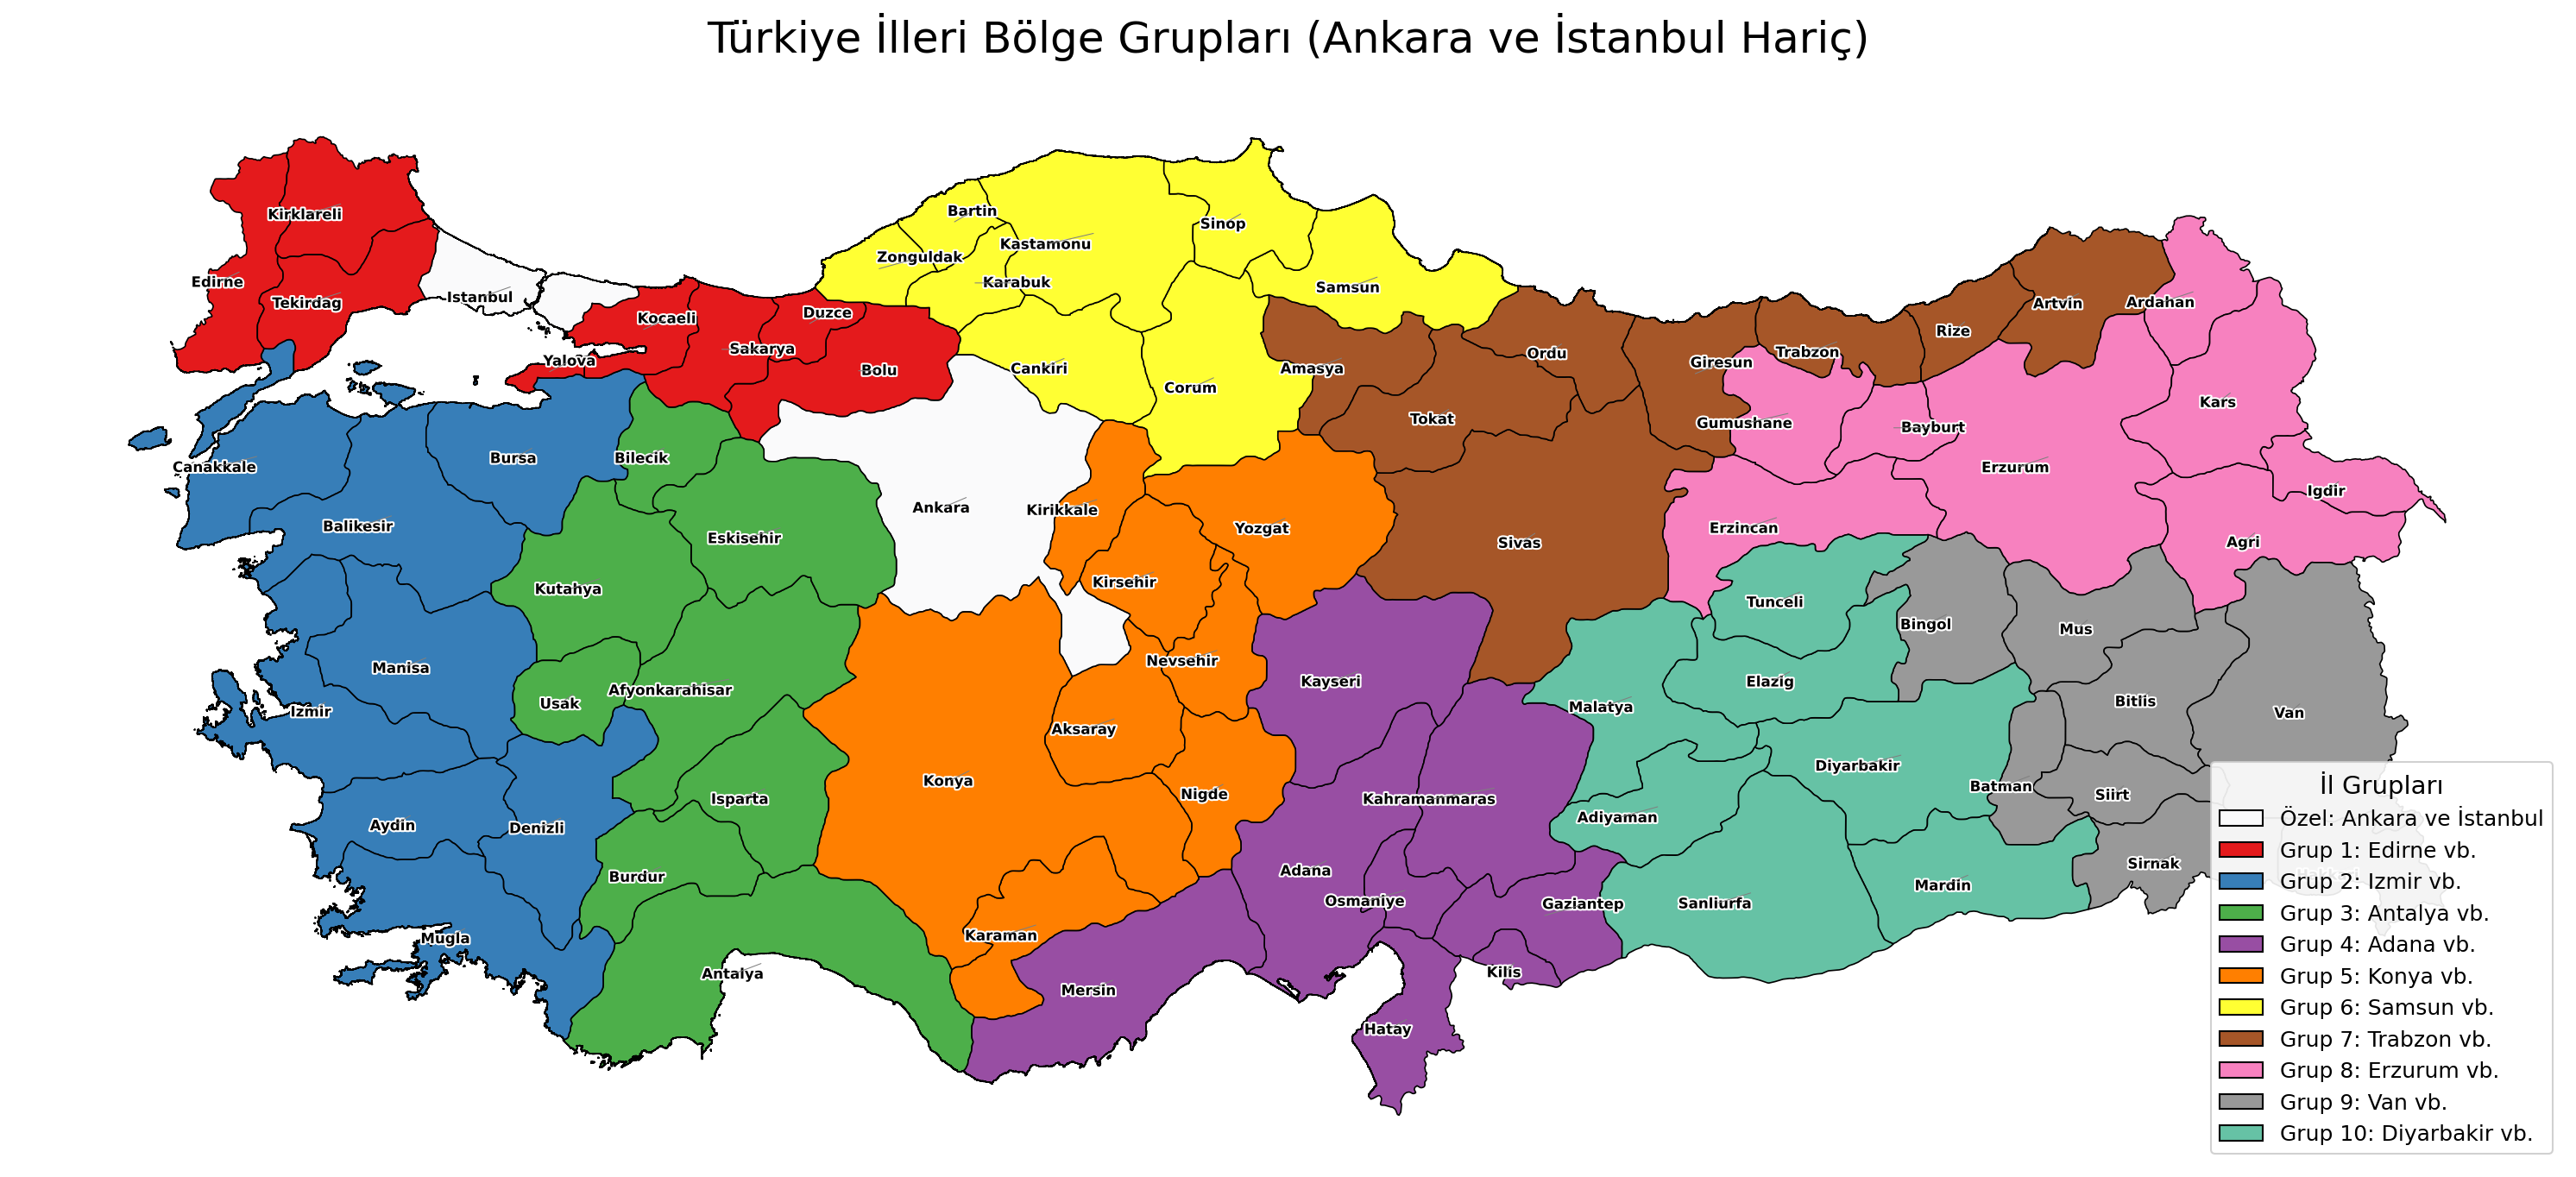

In [83]:
# Harita boyutunu ve çözünürlüğünü ayarlama
plt.figure(figsize=(20, 15), dpi=150)
ax = plt.gca()

# Haritayı çizdirme
turkiye_iller.plot(
    column='Grup',
    categorical=True,
    cmap=cmap,
    linewidth=0.8,
    edgecolor='black',
    ax=ax
)

# İl merkezlerini hesaplama
turkiye_iller['center'] = turkiye_iller.geometry.centroid

# İl isimlerini ekleme
texts = []
for idx, row in turkiye_iller.iterrows():
    texts.append(plt.text(
        row['center'].x, 
        row['center'].y, 
        row['İl'], 
        fontsize=8,
        ha='center',
        va='center',
        color='black',
        fontweight='bold',
        path_effects=[path_effects.withStroke(linewidth=2, foreground='white')]  # Düzeltilmiş satır
    ))

# İsimlerin çakışmasını önleme
aT.adjust_text(
    texts, 
    force_points=0.5, 
    force_text=0.8, 
    expand_points=(1,1), 
    expand_text=(1,1),
    arrowprops=dict(arrowstyle="-", color='grey', lw=0.5)
)

# Lejand oluşturma
legend_elements = []
# Önce özel grup (Ankara ve İstanbul)
legend_elements.append(
    Patch(facecolor=group_colors[0], edgecolor='black', label="Özel: Ankara ve İstanbul")
)
# Sonra diğer gruplar
for i in range(1, 11):
    # Grup için örnek il
    sample_province = standardized_groups[i][0] if i in standardized_groups and standardized_groups[i] else f"Grup {i}"
    legend_elements.append(
        Patch(facecolor=group_colors[i], edgecolor='black', label=f"Grup {i}: {sample_province} vb.")
    )

ax.legend(
    handles=legend_elements, 
    title="İl Grupları", 
    title_fontsize=14,
    fontsize=12,
    loc='lower right',
    frameon=True,
    framealpha=0.9
)

# Harita başlığı ve eksenleri düzenleme
plt.title("Türkiye İlleri Bölge Grupları (Ankara ve İstanbul Hariç)", fontsize=24, pad=20)
plt.axis('off')

# Harita çerçevesini ayarlama
plt.tight_layout()

# Haritayı gösterme
plt.show()

## Yüksek Kaliteli Harita Kaydetme

Oluşturduğumuz haritayı yüksek çözünürlükte kaydedelim.

Harita başarıyla kaydedildi!


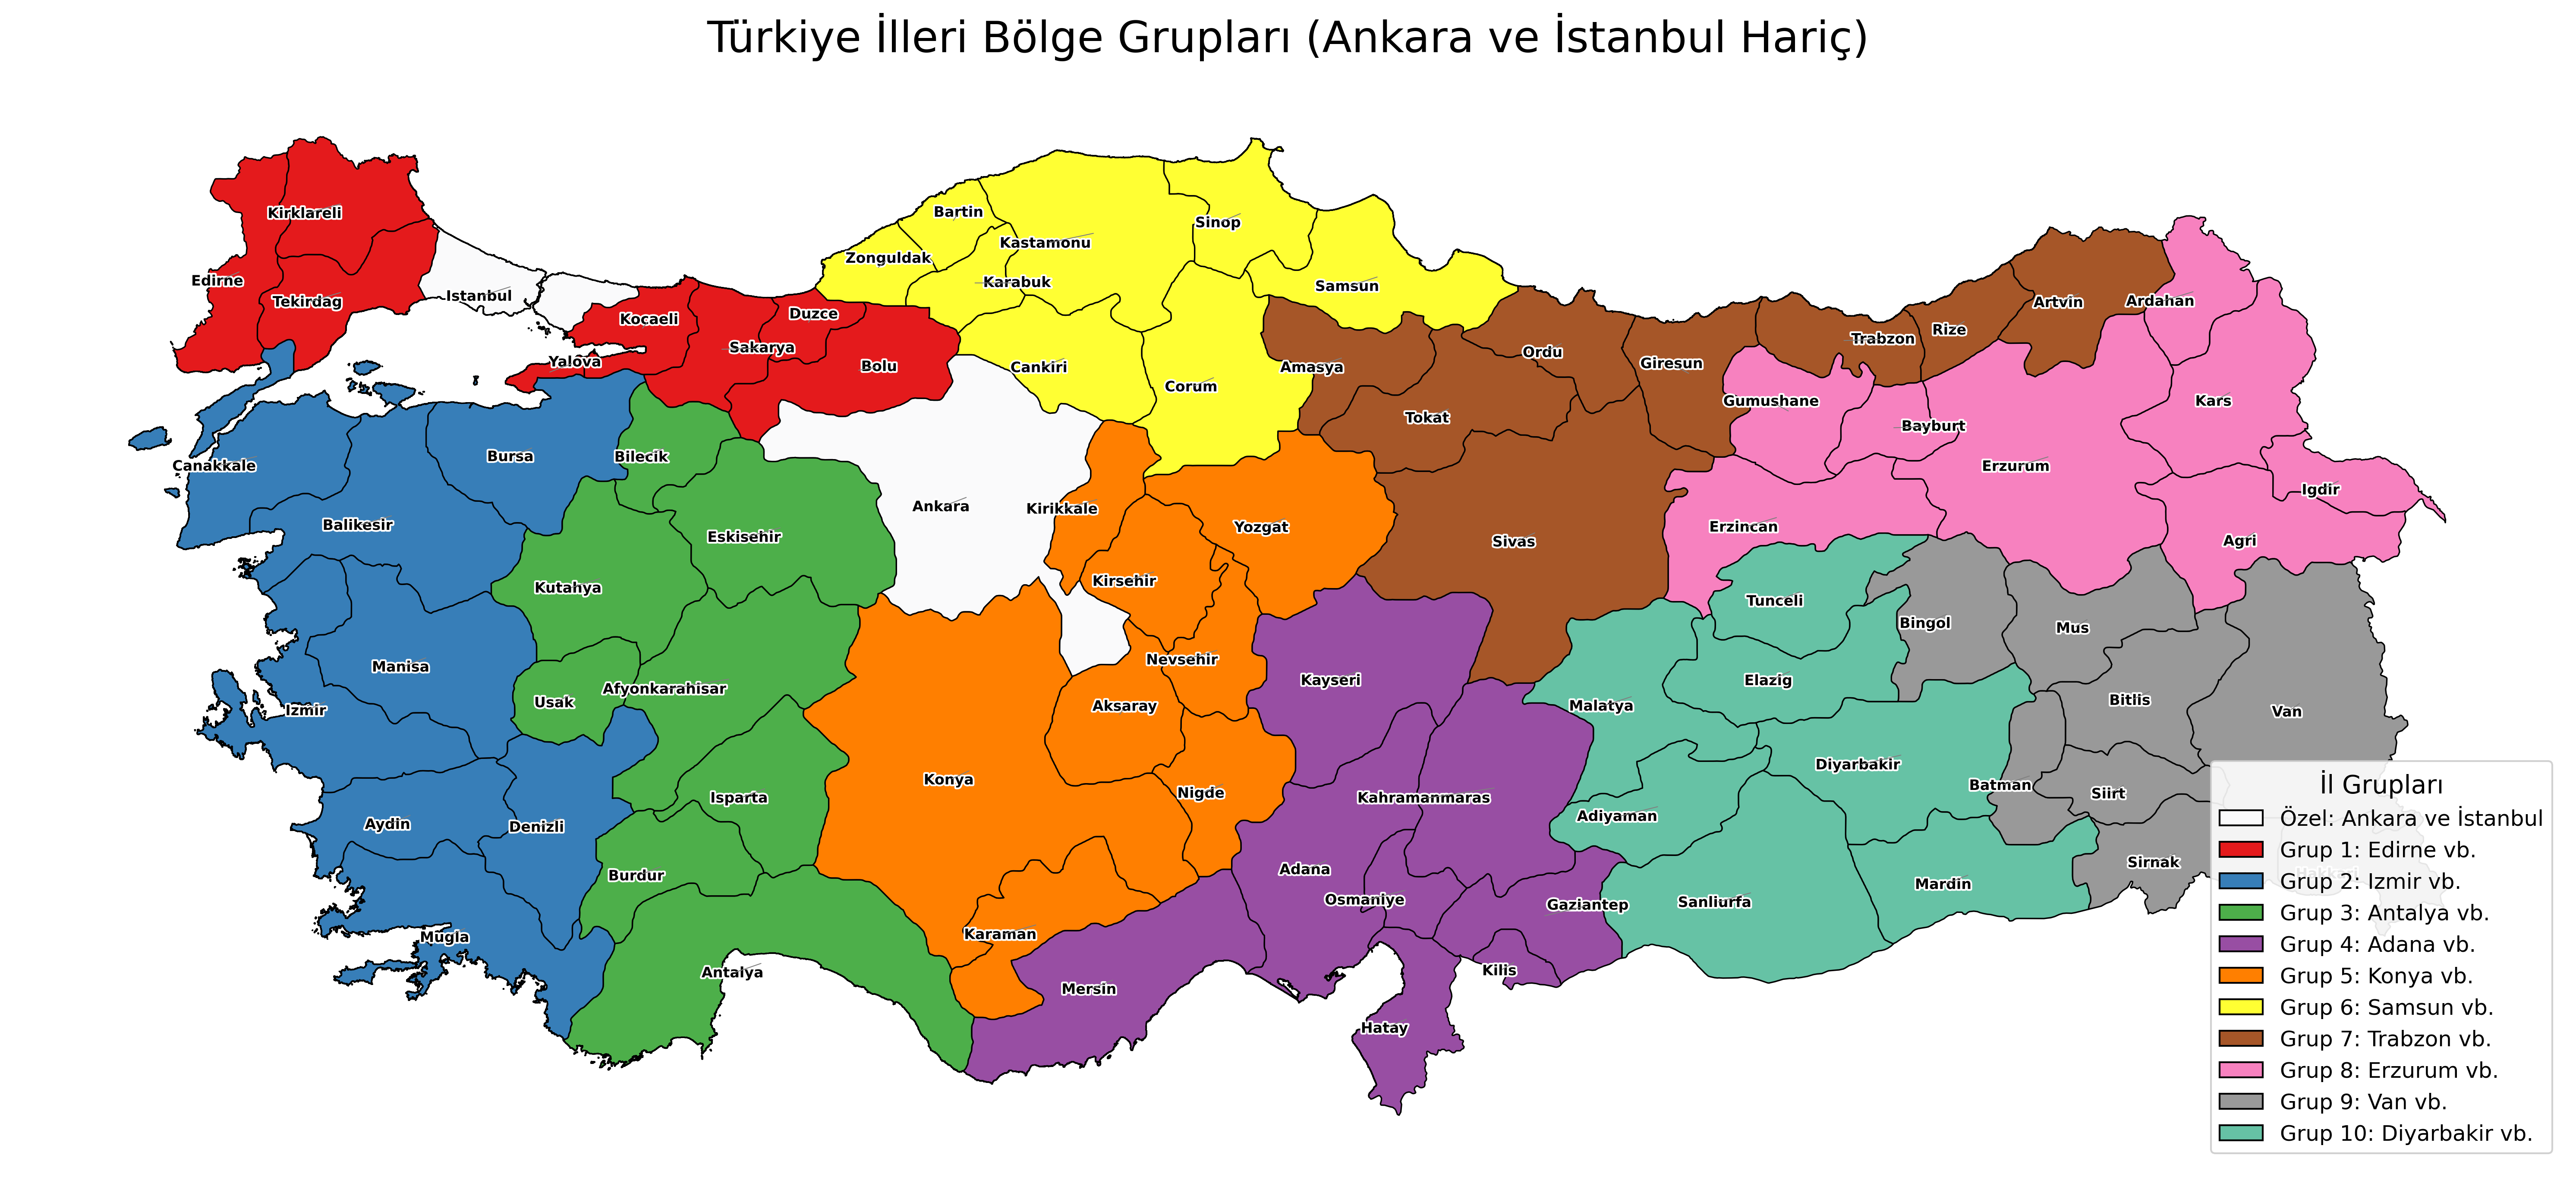

In [84]:
# Yüksek çözünürlüklü görsel için yeniden oluşturma
plt.figure(figsize=(20, 15), dpi=300)
ax = plt.gca()

# Haritayı çizdirme
turkiye_iller.plot(
    column='Grup',
    categorical=True,
    cmap=cmap,
    linewidth=0.8,
    edgecolor='black',
    ax=ax
)

# İsimlerin yeniden yerleştirilmesi
texts = []
for idx, row in turkiye_iller.iterrows():
    texts.append(plt.text(
        row['center'].x, 
        row['center'].y, 
        row['İl'], 
        fontsize=8,
        ha='center',
        va='center',
        color='black',
        fontweight='bold',
        path_effects=[path_effects.withStroke(linewidth=2, foreground='white')]
    ))

aT.adjust_text(
    texts, 
    force_points=0.5, 
    force_text=0.8, 
    expand_points=(1,1), 
    expand_text=(1,1),
    arrowprops=dict(arrowstyle="-", color='grey', lw=0.5)
)

# Lejand oluşturma
legend_elements = []
# Önce özel grup (Ankara ve İstanbul)
legend_elements.append(
    Patch(facecolor=group_colors[0], edgecolor='black', label="Özel: Ankara ve İstanbul")
)
# Sonra diğer gruplar
for i in range(1, 11):
    sample_province = standardized_groups[i][0] if i in standardized_groups and standardized_groups[i] else f"Grup {i}"
    legend_elements.append(
        Patch(facecolor=group_colors[i], edgecolor='black', label=f"Grup {i}: {sample_province} vb.")
    )

ax.legend(
    handles=legend_elements, 
    title="İl Grupları", 
    title_fontsize=14,
    fontsize=12,
    loc='lower right',
    frameon=True,
    framealpha=0.9
)

# Harita başlığı ve eksenleri düzenleme
plt.title("Türkiye İlleri Bölge Grupları (Ankara ve İstanbul Hariç)", fontsize=24, pad=20)
plt.axis('off')
plt.tight_layout()

# Haritayı yüksek çözünürlükte kaydetme
plt.savefig('turkiye_il_gruplari.png', dpi=300, bbox_inches='tight')
plt.savefig('turkiye_il_gruplari.svg', format='svg', bbox_inches='tight')

print("Harita başarıyla kaydedildi!")

## İl İsimleri Olmadan Harita Oluşturma

İllerin isimlerinin görünmediği, sadece grup renklerinin görüldüğü harita oluşturalım.

İsimsiz harita başarıyla kaydedildi!


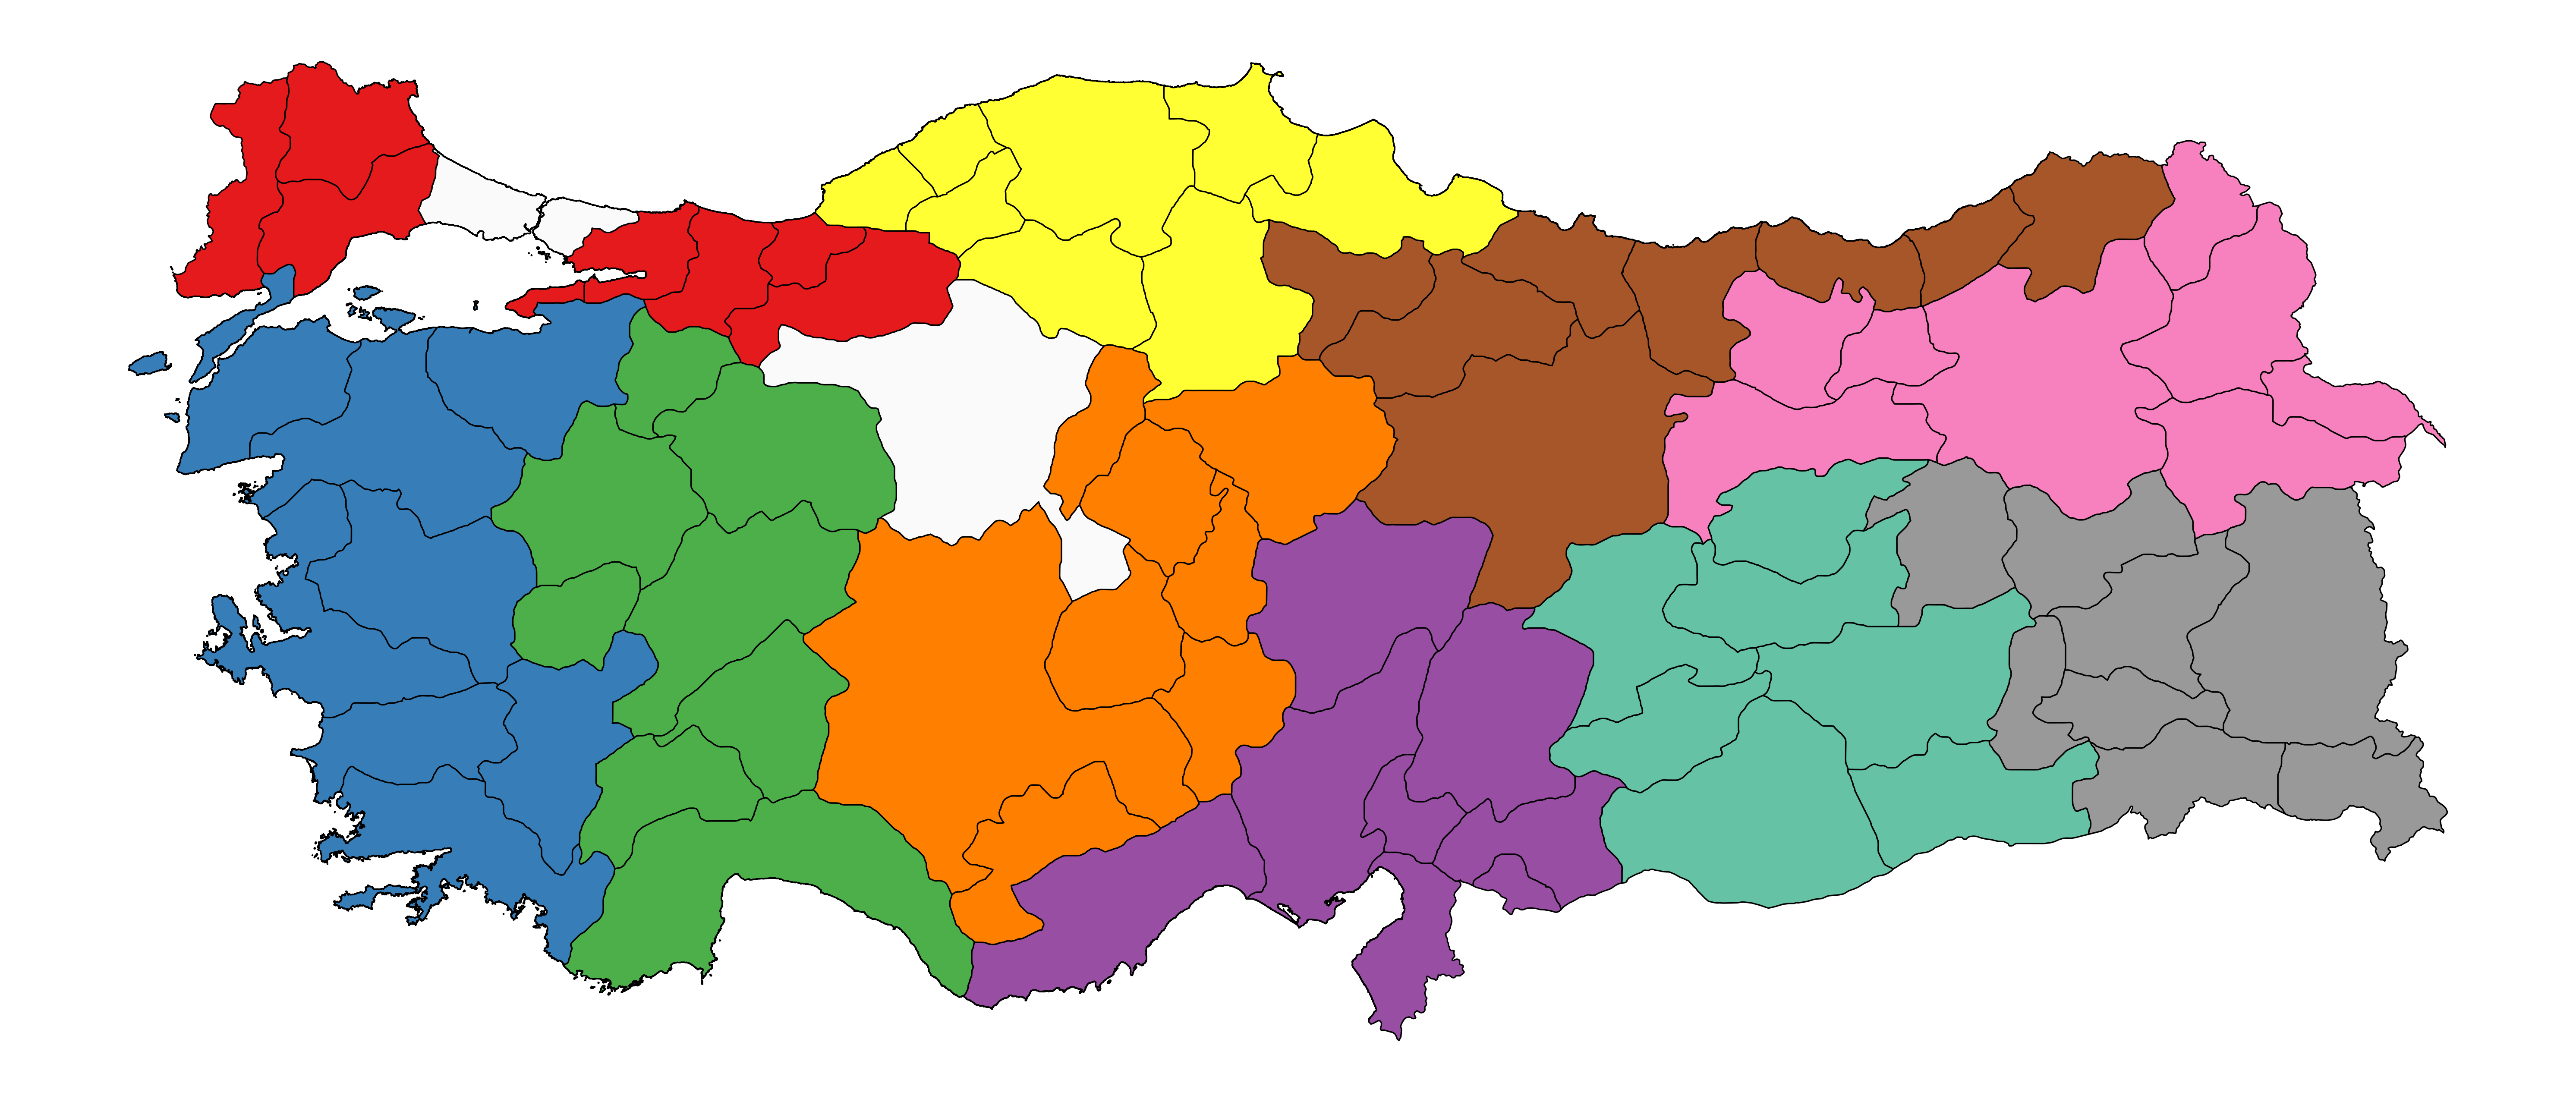

In [85]:
# İl isimleri olmadan harita oluşturma (hiçbir metin içermeden)
plt.figure(figsize=(20, 15), dpi=300)
ax = plt.gca()

# Haritayı çizdirme
turkiye_iller.plot(
    column='Grup',
    categorical=True,
    cmap=cmap,
    linewidth=0.8,
    edgecolor='black',
    ax=ax
)

# Eksenleri gizle
plt.axis('off')
plt.tight_layout()

# Haritayı isimsiz versiyonuyla kaydetme
plt.savefig('turkiye_il_gruplari_isimsiz.png', dpi=300, bbox_inches='tight')
plt.savefig('turkiye_il_gruplari_isimsiz.svg', format='svg', bbox_inches='tight')

print("İsimsiz harita başarıyla kaydedildi!")

## İl İsimleriyle Harita Oluşturma

İllerin isimlerinin göründüğü detaylı haritayı oluşturalım. Bu haritada il sınırlarıyla birlikte her ilin adı görünecektir.

İsimli harita başarıyla kaydedildi!


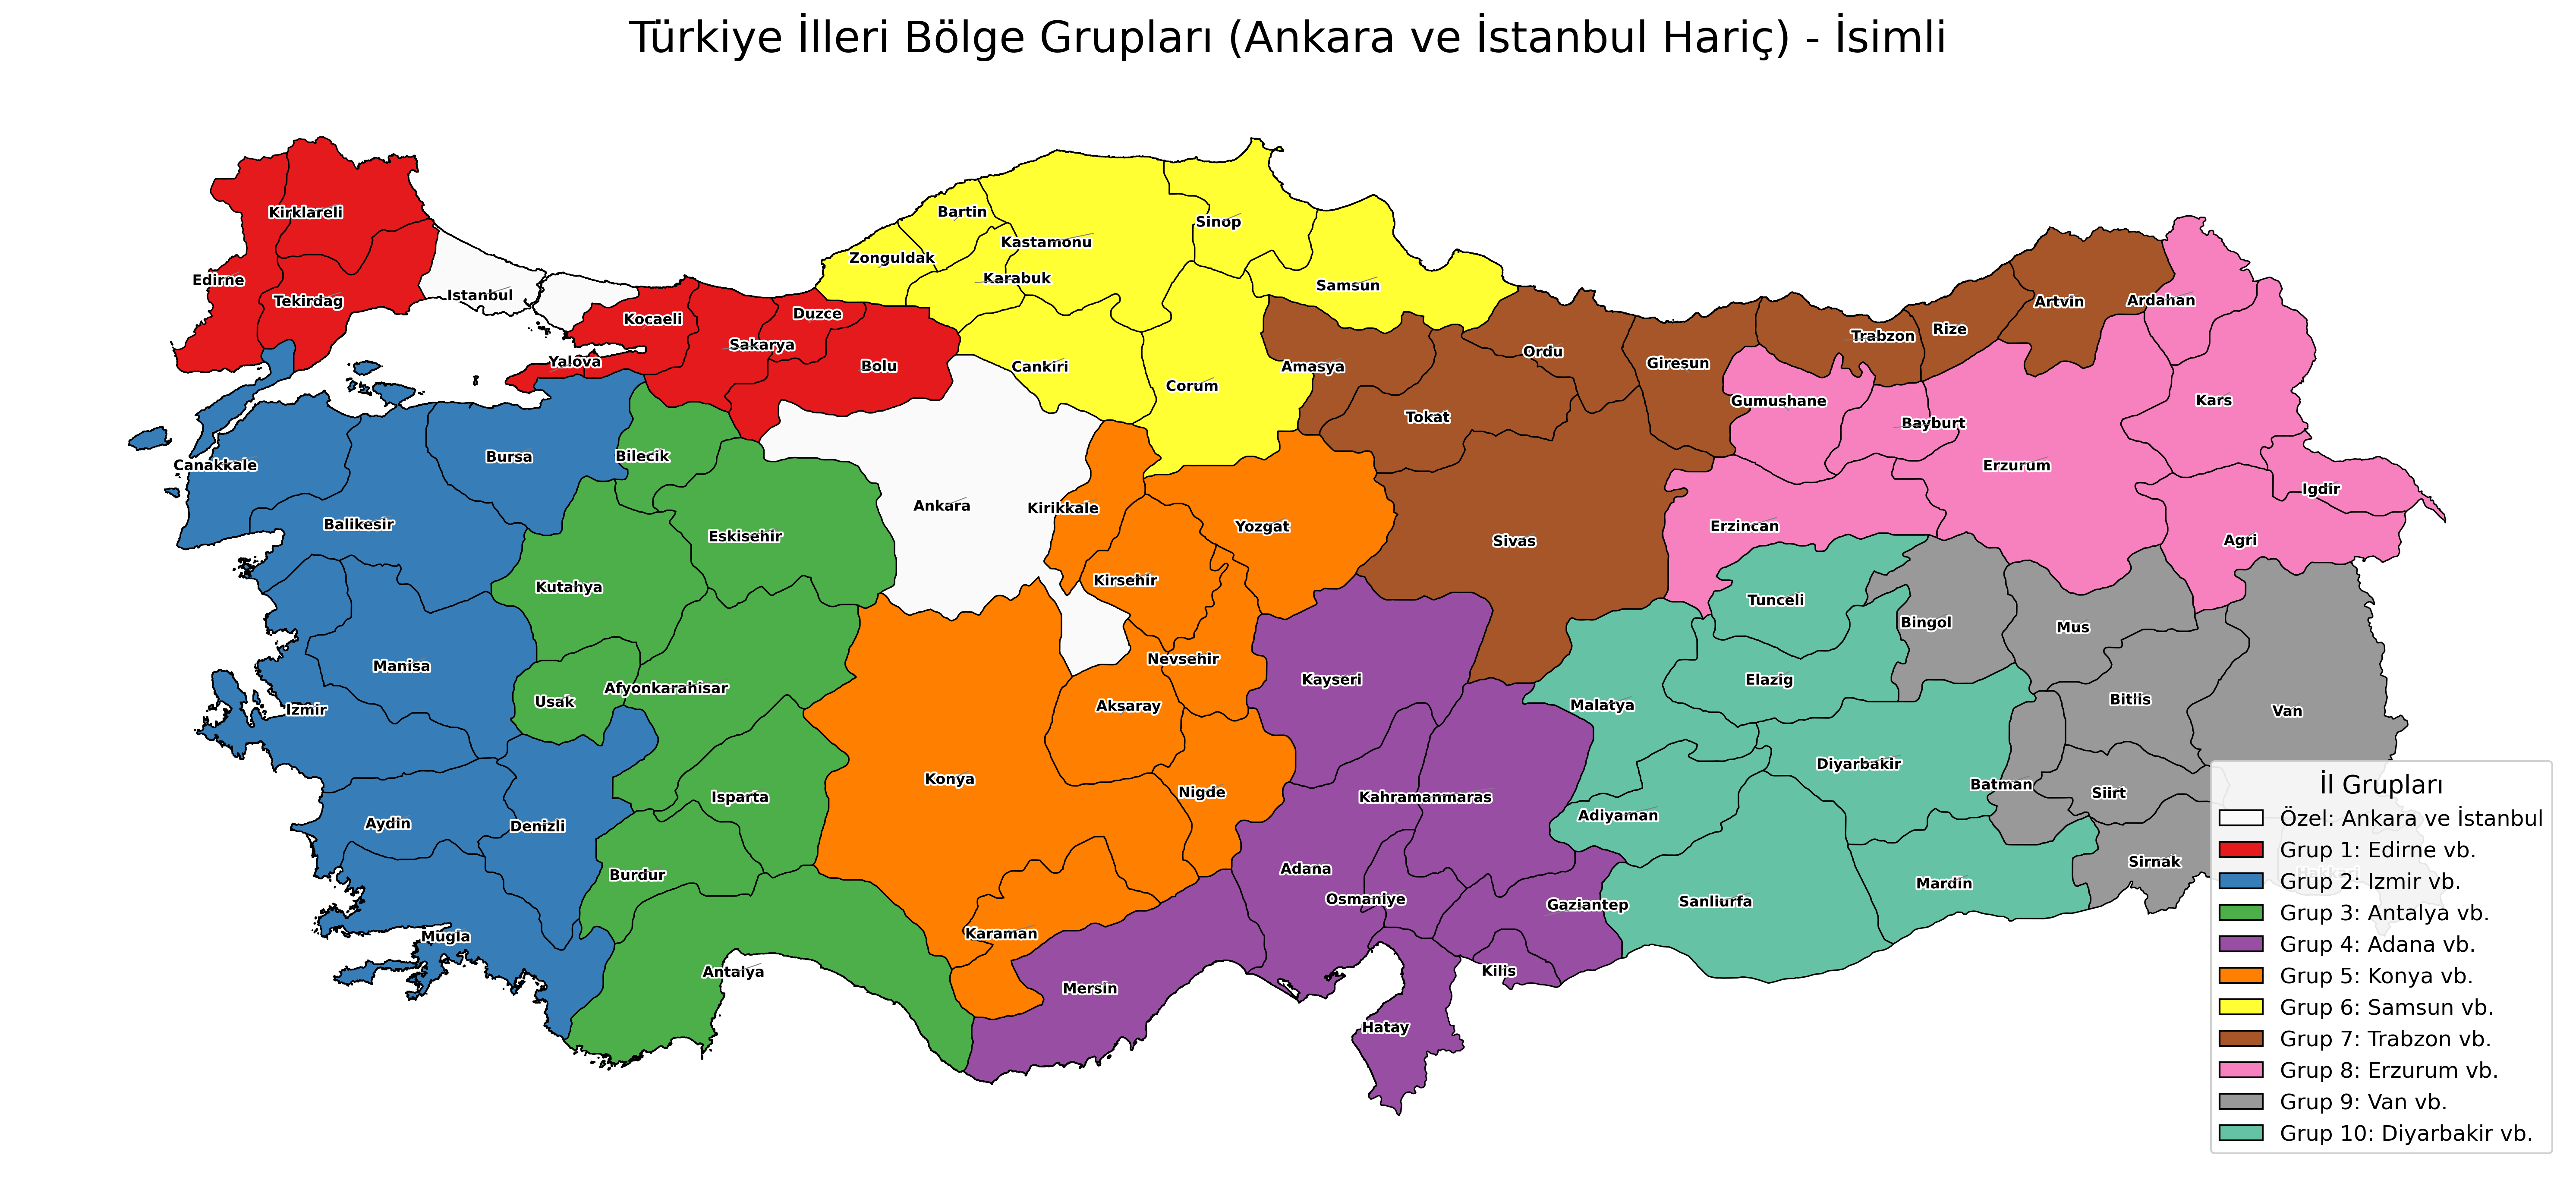

In [86]:
# İl isimleriyle harita oluşturma
plt.figure(figsize=(20, 15), dpi=300)
ax = plt.gca()

# Haritayı çizdirme
turkiye_iller.plot(
    column='Grup',
    categorical=True,
    cmap=cmap,
    linewidth=0.8,
    edgecolor='black',
    ax=ax
)

# İl merkezlerini hesaplama (eğer daha önce hesaplanmamışsa)
if 'center' not in turkiye_iller.columns:
    turkiye_iller['center'] = turkiye_iller.geometry.centroid

# İl isimlerini ekleme
texts = []
for idx, row in turkiye_iller.iterrows():
    texts.append(plt.text(
        row['center'].x, 
        row['center'].y, 
        row['İl'], 
        fontsize=8,
        ha='center',
        va='center',
        color='black',
        fontweight='bold',
        path_effects=[path_effects.withStroke(linewidth=2, foreground='white')]
    ))

# İsimlerin çakışmasını önleme
aT.adjust_text(
    texts, 
    force_points=0.5, 
    force_text=0.8, 
    expand_points=(1,1), 
    expand_text=(1,1),
    arrowprops=dict(arrowstyle="-", color='grey', lw=0.5)
)

# Lejand oluşturma
legend_elements = []
# Önce özel grup (Ankara ve İstanbul)
legend_elements.append(
    Patch(facecolor=group_colors[0], edgecolor='black', label="Özel: Ankara ve İstanbul")
)
# Sonra diğer gruplar
for i in range(1, 11):
    sample_province = standardized_groups[i][0] if i in standardized_groups and standardized_groups[i] else f"Grup {i}"
    legend_elements.append(
        Patch(facecolor=group_colors[i], edgecolor='black', label=f"Grup {i}: {sample_province} vb.")
    )

ax.legend(
    handles=legend_elements, 
    title="İl Grupları", 
    title_fontsize=14,
    fontsize=12,
    loc='lower right',
    frameon=True,
    framealpha=0.9
)

# Harita başlığı ve eksenleri düzenleme
plt.title("Türkiye İlleri Bölge Grupları (Ankara ve İstanbul Hariç) - İsimli", fontsize=24, pad=20)
plt.axis('off')
plt.tight_layout()

# Haritayı isimli versiyonuyla kaydetme
plt.savefig('turkiye_il_gruplari_isimli.png', dpi=300, bbox_inches='tight')
plt.savefig('turkiye_il_gruplari_isimli.svg', format='svg', bbox_inches='tight')

print("İsimli harita başarıyla kaydedildi!")

## Referanslar

1. [Creating a population map of Turkey with Geopandas](https://www.youtube.com/watch?v=4ox02WgiTWk)
2. [GeoPandas Documentation](https://geopandas.org/)
3. [Matplotlib Documentation](https://matplotlib.org/)
4. [adjustText Library](https://github.com/Phlya/adjustText)